In [188]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from galton import galton_rvs, galton_rvs_ratio

In [63]:
from galton import n_nails 
from galton import n_rows
theta_0 = -0.8
theta_1 = -0.6

# Density estimation with histograms

In [177]:
samples_0, _, scores_0, _ = galton_rvs(theta_0, n_runs=20000, random_state=1234)
p_estimated_0, _ = np.histogram(samples_0, bins=n_nails, range=(0, n_nails), density=True)

samples_1, _, scores_1, _ = galton_rvs(theta_1, n_runs=20000, random_state=1234)
p_estimated_1, _ = np.histogram(samples_1, bins=n_nails, range=(0, n_nails), density=True)

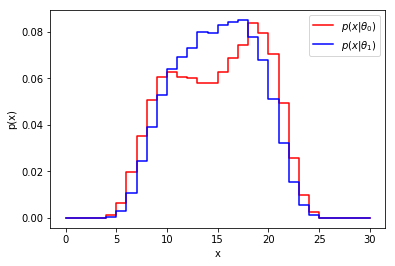

In [178]:
plt.step(range(len(p_estimated_0)), p_estimated_0,
         c='r', lw=1.5,
         label=r'$p(x|\theta_0)$')
plt.step(range(len(p_estimated_0)), p_estimated_1,
         c='b', lw=1.5, 
         label=r'$p(x|\theta_1)$')

plt.xlabel("x")
plt.ylabel("p(x)")
plt.legend()
plt.show()

/home/gilles/anaconda3/envs/simulator-mining-example/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


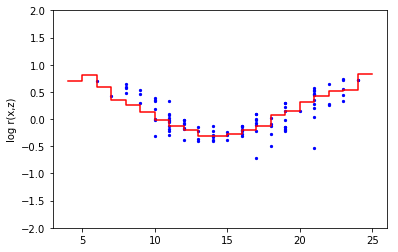

In [179]:
plt.step(range(len(p_estimated_0)), np.log(p_estimated_0/p_estimated_1),
         c='r', lw=1.5,
         label=r'$p(x|\theta_0)$')
plt.scatter(samples, np.array(log_p0) - np.array(log_p1), s=5., c='b')
plt.ylabel('log r(x,z)')
plt.ylim(-2.,2.)
plt.show()

# NDE + SCANDAL

In [ ]:
from galton import check_random_state

def draw(n_samples, n_thetas=10, random_state=0):
    n_traces_per_theta = n_samples // n_thetas
    
    all_x = []
    all_t_xz = []
    all_thetas = []
    
    for k, theta in enumerate(np.linspace(-1.0, -0.4, n_thetas)):
        x, log_p_xz, t_xz, _ = galton_rvs(theta, n_runs=n_traces_per_theta, random_state=random_state+k)
        all_x.append(x)
        all_t_xz.append(t_xz)
        all_thetas.append(theta * np.ones(n_traces_per_theta))
        
    all_x = np.array(all_x).reshape(-1, 1)
    all_x = to_categorical(all_x, num_classes=n_nails)
    all_t_xz = np.array(all_t_xz).reshape(-1, 1)
    all_thetas = np.array(all_thetas).reshape(-1, 1)
    
    rng = check_random_state(random_state)
    choices = rng.choice(len(all_x), len(all_x), replace=False)
        
    return all_x[choices], all_t_xz[choices], all_thetas[choices]

In [ ]:
x, t_xz, theta = draw(10000)

In [191]:
n_features = 1 
hidden_size = 10
n_outputs = n_nails

In [192]:
from keras.optimizers import Adam
from keras.layers import Input, Dense, Lambda, dot
from keras.models import Model
from keras.utils import to_categorical
import keras.backend as K

def make_nde(lr=0.001):   
    theta = Input(shape=(1,))
    h = Dense(hidden_size, activation="tanh")(theta)
    phat_theta = Dense(n_outputs, activation="softmax")(h)
    
    model = Model(inputs=[theta], outputs=[phat_theta])
    opt = Adam(lr=lr)
    model.compile(loss=["categorical_crossentropy"], optimizer=opt)
    
    return model

def make_scandal(lr=0.001):
    theta = Input(shape=(1,))
    h = Dense(hidden_size, activation="tanh")(theta)
    phat_theta = Dense(n_outputs, activation="softmax")(h)
    
    x = Input(shape=(n_outputs,))
    phat_x_theta = dot([x, phat_theta], axes=1) 
    t_x = Lambda(lambda exp: K.gradients(K.log(exp[0]), [exp[1]])[0], 
                 output_shape=(n_features,))([phat_x_theta, theta])
    
    model = Model(inputs=[theta, x], outputs=[phat_theta, t_x])
    opt = Adam(lr=lr)
    model.compile(loss=["categorical_crossentropy", "mse"], optimizer=opt)
    
    return model

In [193]:
nde = make_nde()
nde.fit(theta, x, batch_size=32, epochs=50)

Epoch 1/50
20000/20000 [==============================] - 2s 86us/step - loss: 3.0053
Epoch 2/50
20000/20000 [==============================] - 1s 43us/step - loss: 2.8309
Epoch 3/50
20000/20000 [==============================] - 1s 45us/step - loss: 2.8205
Epoch 4/50
20000/20000 [==============================] - 1s 45us/step - loss: 2.8145
Epoch 5/50
20000/20000 [==============================] - 1s 42us/step - loss: 2.8088
Epoch 6/50
20000/20000 [==============================] - 1s 43us/step - loss: 2.8036
Epoch 7/50
20000/20000 [==============================] - 1s 43us/step - loss: 2.7989
Epoch 8/50
20000/20000 [==============================] - 1s 44us/step - loss: 2.7950
Epoch 9/50
20000/20000 [==============================] - 1s 43us/step - loss: 2.7922
Epoch 10/50
20000/20000 [==============================] - 1s 44us/step - loss: 2.7900
Epoch 11/50
20000/20000 [==============================] - 1s 43us/step - loss: 2.7884
Epoch 12/50
20000/20000 [===========================

In [194]:
scandal = make_scandal()
scandal.fit([theta, x], [x, t_xz], batch_size=32, epochs=50)

Epoch 1/50
20000/20000 [==============================] - 2s 102us/step - loss: 4.7529 - dense_96_loss: 3.1483 - lambda_84_loss: 1.6046
Epoch 2/50
20000/20000 [==============================] - 1s 59us/step - loss: 3.9478 - dense_96_loss: 2.8615 - lambda_84_loss: 1.0863
Epoch 3/50
20000/20000 [==============================] - 1s 59us/step - loss: 3.8393 - dense_96_loss: 2.8034 - lambda_84_loss: 1.0360
Epoch 4/50
20000/20000 [==============================] - 1s 58us/step - loss: 3.7965 - dense_96_loss: 2.7917 - lambda_84_loss: 1.0048
Epoch 5/50
20000/20000 [==============================] - 1s 60us/step - loss: 3.7704 - dense_96_loss: 2.7879 - lambda_84_loss: 0.9825
Epoch 6/50
20000/20000 [==============================] - 1s 58us/step - loss: 3.7538 - dense_96_loss: 2.7859 - lambda_84_loss: 0.9679
Epoch 7/50
20000/20000 [==============================] - 1s 61us/step - loss: 3.7438 - dense_96_loss: 2.7854 - lambda_84_loss: 0.9584
Epoch 8/50
20000/20000 [==============================

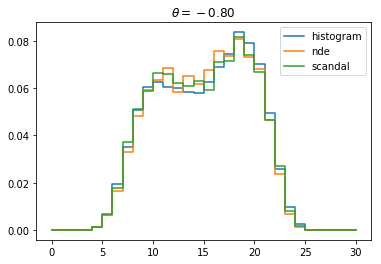

In [195]:
plt.step(range(n_nails), p_estimated_0, label="histogram")
plt.step(range(n_nails), nde.predict([theta_0]).ravel(), label="nde")
plt.step(range(n_nails), scandal.predict([np.array([[theta_0]]), np.zeros((1, n_nails))])[0][0], label="scandal")
plt.legend()
plt.title(r"$\theta=%.2f$" % theta_0)
plt.show()

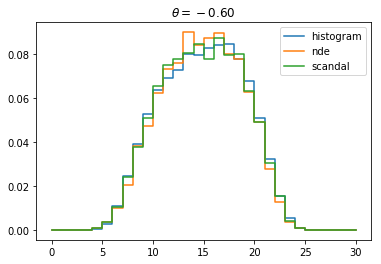

In [196]:
plt.step(range(n_nails), p_estimated_1, label="histogram")
plt.step(range(n_nails), nde.predict([theta_1]).ravel(), label="nde")
plt.step(range(n_nails), scandal.predict([np.array([[theta_1]]), np.zeros((1, n_nails))])[0][0], label="scandal")
plt.legend()
plt.title(r"$\theta=%.2f$" % theta_1)
plt.show()

# CARL

# ROLR + RASCAL

In [441]:
from galton import check_random_state
from itertools import product

def draw_ratio(n_samples, n_thetas=10, random_state=0):
    grid = list(product(np.linspace(-1.0, -0.4, n_thetas), 
                        np.linspace(-1.0, -0.4, n_thetas)))
    n_traces_per_theta = n_samples // len(grid)
    
    rng = check_random_state(random_state)
    
    all_x = []
    all_log_r_xz = []
    all_t_xz_0 = []
    all_thetas = []
  
    # draw from theta_1
    for theta_0, theta_1 in grid:
        x, log_p_xz_1, log_p_xz_0, _, t_xz_0, _ = galton_rvs_ratio(theta_1, theta_0, n_runs=n_traces_per_theta, random_state=rng)
        all_x.append(x)
        all_log_r_xz.append(log_p_xz_0 - log_p_xz_1)
        all_t_xz_0.append(t_xz_0)
        all_thetas.append(np.tile(np.array([theta_0, theta_1]), (n_traces_per_theta, 1)))
        
    # reshape
    all_x = np.array(all_x).reshape(-1, 1)
    all_x = to_categorical(all_x, num_classes=n_nails)
    all_log_r_xz = np.array(all_log_r_xz).reshape(-1, 1)
    all_t_xz_0 = np.array(all_t_xz_0).reshape(-1, 1)
    all_thetas = np.vstack(all_thetas)
    
    choices = rng.choice(len(all_x), len(all_x), replace=False)
        
    return all_x[choices], all_thetas[choices], all_log_r_xz[choices], all_t_xz_0[choices]

In [442]:
x, thetas, log_r_xz, t_xz_0 = draw_ratio(10000, n_thetas=10)

In [486]:
from keras.losses import mean_squared_error
from keras.layers import concatenate

def make_rolr(lr=0.001):
    theta0 = Input(shape=(1,))
    theta1 = Input(shape=(1,))
    thetas = concatenate([theta0, theta1])
    
    h = Dense(hidden_size, activation="tanh")(thetas)
    log_rhat_thetas = Dense(n_outputs, activation="linear")(h)
    rhat_thetas = Lambda(lambda exp: K.exp(exp))(log_rhat_thetas)
    
    x = Input(shape=(n_outputs,))
    rhat_x_thetas = dot([x, rhat_thetas], axes=1)
    
    model = Model(inputs=[theta0, theta1, x], outputs=[rhat_x_thetas])
    opt = Adam(lr=lr)
    model.compile(loss=["mse"], optimizer=opt)
    
    return model

def make_rascal(lr=0.001):
    theta0 = Input(shape=(1,))
    theta1 = Input(shape=(1,))
    thetas = concatenate([theta0, theta1])
    
    h = Dense(hidden_size, activation="tanh")(thetas)
    log_rhat_thetas = Dense(n_outputs, activation="linear")(h)
    rhat_thetas = Lambda(lambda exp: K.exp(exp))(log_rhat_thetas)
    
    x = Input(shape=(n_outputs,))
    rhat_x_thetas = dot([x, rhat_thetas], axes=1)
    
    log_rhat_x_theta = dot([x, log_rhat_thetas], axes=1) 
    t_x_0 = Lambda(lambda exp: K.gradients(exp[0], [exp[1]])[0], 
                   output_shape=(n_features,))([log_rhat_x_theta, theta0])
    
    model = Model(inputs=[theta0, theta1, x], outputs=[rhat_x_thetas, t_x_0])
    opt = Adam(lr=lr)
    model.compile(loss=["mse", "mse"], loss_weights=[1.0, 0.5], optimizer=opt)
    
    return model

In [488]:
rolr = make_rolr()
rolr.fit([thetas[:, 0], 
          thetas[:, 1], 
          x], 
         np.exp(log_r_xz), 
         batch_size=32, epochs=50)

Epoch 1/50
10000/10000 [==============================] - 3s 255us/step - loss: 0.2428
Epoch 2/50
10000/10000 [==============================] - 1s 64us/step - loss: 0.2091
Epoch 3/50
10000/10000 [==============================] - 1s 67us/step - loss: 0.1779
Epoch 4/50
10000/10000 [==============================] - 1s 67us/step - loss: 0.1528
Epoch 5/50
10000/10000 [==============================] - 1s 68us/step - loss: 0.1388
Epoch 6/50
10000/10000 [==============================] - 1s 67us/step - loss: 0.1317
Epoch 7/50
10000/10000 [==============================] - 1s 68us/step - loss: 0.1275
Epoch 8/50
10000/10000 [==============================] - 1s 71us/step - loss: 0.1249
Epoch 9/50
10000/10000 [==============================] - 1s 70us/step - loss: 0.1231
Epoch 10/50
10000/10000 [==============================] - 1s 68us/step - loss: 0.1219
Epoch 11/50
10000/10000 [==============================] - 1s 92us/step - loss: 0.1208
Epoch 12/50
10000/10000 [==========================

In [489]:
rascal = make_rascal()
rascal.fit([thetas[:, 0], 
            thetas[:, 1], 
            x], 
           [np.exp(log_r_xz), 
            t_xz_0], 
           batch_size=32, epochs=50)

Epoch 1/50
10000/10000 [==============================] - 3s 262us/step - loss: 1.4856 - dot_54_loss: 0.1957 - lambda_157_loss: 2.5797
Epoch 2/50
10000/10000 [==============================] - 1s 71us/step - loss: 1.0218 - dot_54_loss: 0.1449 - lambda_157_loss: 1.7540
Epoch 3/50
10000/10000 [==============================] - 1s 72us/step - loss: 0.9257 - dot_54_loss: 0.1345 - lambda_157_loss: 1.5825
Epoch 4/50
10000/10000 [==============================] - 1s 86us/step - loss: 0.8846 - dot_54_loss: 0.1308 - lambda_157_loss: 1.5076
Epoch 5/50
10000/10000 [==============================] - 1s 77us/step - loss: 0.8544 - dot_54_loss: 0.1287 - lambda_157_loss: 1.4514
Epoch 6/50
10000/10000 [==============================] - 1s 84us/step - loss: 0.8265 - dot_54_loss: 0.1270 - lambda_157_loss: 1.3988
Epoch 7/50
10000/10000 [==============================] - 1s 75us/step - loss: 0.7979 - dot_54_loss: 0.1245 - lambda_157_loss: 1.3468
Epoch 8/50
10000/10000 [==============================] - 1s 

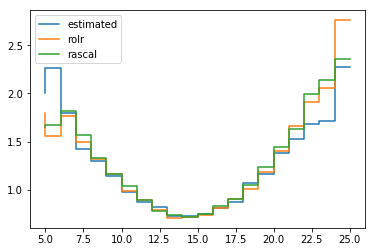

In [491]:
r_true = np.exp(np.log(p_estimated_0[5:-5]) - np.log(p_estimated_1[5:-5]))

x_test = to_categorical(np.array(range(n_nails)), num_classes=n_nails)
r_rolr = rolr.predict([theta_0 * np.ones(n_nails), 
                       theta_1 * np.ones(n_nails),
                       x_test])[5:-5]
r_rascal = rascal.predict([theta_0 * np.ones(n_nails),
                           theta_1 * np.ones(n_nails),
                           x_test])[0][5:-5]

plt.step(range(5, n_nails-5), r_true, label="estimated")
plt.step(range(5, n_nails-5), r_rolr, label="rolr")
plt.step(range(5, n_nails-5), r_rascal, label="rascal")
plt.legend()
plt.show()

---

# Model comparison